# **Real Image to Monet using CycleGAN**

# Import Tensorflow Packages

In [ ]:
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import PIL
import io
import os
import random
import warnings
import zipfile


import tensorflow as tf # tensorflow
from tensorflow import keras
from tensorflow.keras import (
    layers, # tensorflow keras layers
    Model,
    layers,
    optimizers,
    losses,
    utils
)
import tensorflow_addons as tfa

warnings.filterwarnings("ignore")
%matplotlib inline

# Dataset Configuration

In [ ]:
# URL on google cloud storage where dataset is stored
GCS_PATH = KaggleDatasets().get_gcs_path("gan-getting-started")
print(GCS_PATH)

IMAGE_SIZE = [256, 256] # image dimensions

AUTOTUNE = tf.data.experimental.AUTOTUNE

gs://kds-d474c8da7fb6491d2cda9ac9399b9c376986dfae566d20665bf91bfe


# Define dataset functions

Images Data:  
* Size: $256 \text{ x } 256$   
* RGB: $3$ channels    
* Scale: $[-1, 1]$

Functions to extract and process images from files


The **decode_image** function:-




*   Decodes the JPEG-encoded image into a tensor.
Casts the tensor to tf.float32 type.


*   Normalizes the pixel values of the image to the range [-1, 1] by dividing by 127.5 and subtracting 1.

*   Reshapes the tensor to the desired shape specified by IMAGE_SIZE and the number of color channels.





The **read_tfrecord** function serves to process a single example from a TFRecord file.


*   Parsing: It parses a single example from the TFRecord file, extracting the image, its associated name, and the target label (if present) from the example.


*   Image Decoding: It decodes the image data using the decode_image function, converting the encoded image into a tensor suitable for further processing.





The **load_dataset** function is responsible for creating a TensorFlow dataset from TFRecord files.

* Dataset Creation: It creates a TensorFlow dataset (TFRecordDataset) from one or more TFRecord files specified by the filenames argument.

* Data Processing: It applies the read_tfrecord function to each element (record) in the dataset using the map function. This function parses and decodes the image data from each TFRecord example.

* Parallelization: It uses the num_parallel_calls parameter to specify the degree of parallelism when applying the map function. This allows for efficient processing of multiple examples concurrently, improving performance.

In [ ]:
def decode_image(image, channels=3):
    img = tf.image.decode_jpeg(image, channels=channels)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*IMAGE_SIZE, channels])
    return img

def read_tfrecord(input):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    input = tf.io.parse_single_example(input, tfrecord_format)
    image = decode_image(input['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Here we are creating a Monet and Photos datasets consisting of images converted into tensor after pre-processing

In [ ]:
# Load monet dataset
MONET_FILES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
monet_ds = load_dataset(MONET_FILES, labeled=True).batch(1)
print('Monet TFRecord Files:', len(MONET_FILES))

Monet TFRecord Files: 5


In [ ]:
# load photos dataset
PHOTO_FILES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
photo_ds = load_dataset(PHOTO_FILES, labeled=True).batch(1)
print('Photo TFRecord Files:', len(PHOTO_FILES))

Photo TFRecord Files: 20


### Obtain an example image (Monet & Photo)

Observing the features of the images

In [ ]:

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# shape
example_monet.shape, example_photo.shape

(TensorShape([1, 256, 256, 3]), TensorShape([1, 256, 256, 3]))

### Visualize an example image (Monet vs Photo)

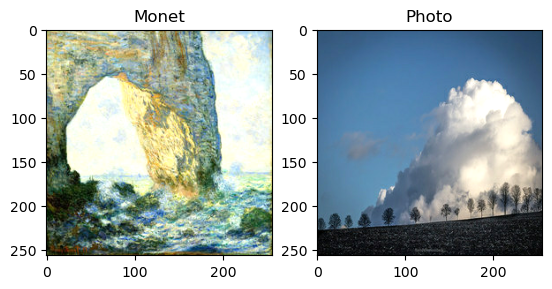

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Monet')
plt.imshow(example_monet[0]* 0.6 + 0.6)

photo = example_photo[0]
plt.subplot(1, 2, 2)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.6 + 0.6)
plt.show()

# Build the Generator in a CycleGan

### Define methods for UNet architecture for CycleGan

This downsample function creates a block to reduce the dimensions in a convolutional neural network.



*   Initializes the weights of the convolutional layers and the scaling factors for instance normalization using random normal distributions.


*   Constructs a sequential model to organize the layers.
Adds a convolutional layer to perform downsampling.

*   Optionally applies instance normalization for stable training dynamics.



*   Applies a leaky rectified linear unit (LeakyReLU) activation function to introduce non-linearity.




In [ ]:
def downsample(filters, size, apply_instancenorm=True):
    # allow you to pre-specify an initialization strategy, encoded in the Initializer object, without knowing the shape and dtype of the variable being initialized.
    initializer = tf.random_normal_initializer(0., 0.02)
    # initializer that generates tensors with a normal distribution
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
    result = keras.Sequential()
    # 2D convolution layer (e.g. spatial convolution over images)
    result.add(layers.Conv2D(filters,
                             size,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False
                            )
              )

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

The **upsample** function performs:-



*   Sequential Model Initialization: Initializes a sequential model to organize the layers.


*   Transposed Convolutional Layer Addition: Adds a transposed convolutional layer to perform upsampling.




*   Instance Normalization: Optionally applies instance normalization for stable training dynamics.

* Dropout (Optional): Optionally applies dropout regularization to prevent overfitting.




In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,
                                      size,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False
                                     )
              )

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Define the generator

- Number of input channels in the image
- Number of filters for the convolutional blocks with ```Conv2D```.

The Generator performs:-


*   Input Layer: Defines the input layer specifying the shape of input images.
* Downsampling Stack: Sequentially applies downsampling blocks to reduce spatial dimensions and increase the number of filters.
* Upsampling Stack: Sequentially applies upsampling blocks to increase spatial dimensions and decrease the number of filters.
* Skip Connections: Utilizes skip connections to preserve low-level details during upsampling.
* Last Layer: Adds a transposed convolutional layer at the end to generate the output image with tanh activation ensuring values in the range [-1, 1].





In [ ]:
def Generator(channels = 3, res_filters=256):
    inputs = layers.Input(shape=[res_filters,res_filters, channels])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(res_filters, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(res_filters, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(filters=channels,
                                  kernel_size=4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh'
                                 )

    x = inputs

    # downsample through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # upsample and stablish skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Initialize a Generator model

In [ ]:
g = Generator() # Initialize a Generator model
g.summary() # get a Generator summary
del g # free up RAM

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_54 (Sequential)     (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_55 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_54[0][0]']          
                                                                                            

### Build the discriminator

Discriminator takes input image and classifies the image as real or generated. Outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a generated classification


The **discriminator** performs:-
* Input Layer: Defines the input layer specifying the shape of input images.
* Downsampling Blocks: Sequentially applies downsampling blocks to reduce spatial dimensions and increase the number of filters.
* Convolutional Layers: Utilizes convolutional layers to further process downsampled feature maps and extract higher-level features.
* Normalization and Activation: Applies instance normalization and leaky ReLU activation to introduce non-linearity and stabilize training.
* Final Layer: Adds a final convolutional layer to produce a single scalar output representing the discriminator's confidence in the input image being real or fake.

In [ ]:
def Discriminator(channels=3, res_filters=256, conv_filters=None):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[res_filters, res_filters, channels], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(filters=1,
                         kernel_size=4,
                         strides=1,
                         kernel_initializer=initializer
                        )(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

## Initialize a Discriminator model

In [ ]:
d = Discriminator() # Initialize a Discriminator model
d.summary() # get a Discriminator summary
del d # free up RAM

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_69 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_70 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_71 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 34, 34, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to photo-like

    monet_discriminator = Discriminator() # differentiates real Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos

# Build the CycleGAN model

Define a CycleGan model
- Generator and Discriminator for the Monet paintings
- Generator and Discriminator for the real-life photos

The forward pass takes a real-life photo and a Monet painting:

Step 1:
- converts the real-life photo to Monet-esque painting using the generator for Monet paintings in```fake_monet```
- converts the Monet painting to real-life photo using the generator for real-life photos in```fake_photo```

Step 2:
- recreates the real-life photo from ```fake_monet``` in ```cycled_photo```
- recreates the Monet painting from ```fake_photo``` in ```cycled_monet```

Step 3:
- passes real Monet painting through Monet generator to test how good the generator is at recognizing its own paintings in  ``identity_monet```
- passes real photo through real-life photo generator to test how good the generator is at recognizing its own photos in ``identity_photo```

Step 4:
- Classifies the real Monet painting using the Monet paintings discriminator. Expected output should be close to 1 in ```discriminated_real_monet``` since Monet painting is not generated.
- Classifies the real real-life photo using the real-life photo discriminator. Expected output should be close to 1 in ```discriminated_real_photo``` since real-life photo is not generated.

Step 5:
- Classifies the fake Monet painting ```fake_monet``` using the Monet paintings discriminator. Expected output should be close to 0 in ```discriminated_fake_monet``` since ```fake_monet``` is generated.
- Classifies the fake real-life photo ```fake_photo``` using the real-life photo discriminator. Expected output should be close to 0 in ```discriminated_fake_photo``` since ```fake_photo``` is generated.

Outputs are returned in a dictionary.

* Real images are passed through the generators to generate fake images.
* Cycle consistency is enforced by reconstructing original images from generated images.
* Identity loss is computed by reconstructing original images from themselves.
* Discriminator losses are evaluated for both real and fake images.
* Total losses for generators and discriminators are calculated.
Gradients of losses are computed with respect to trainable variables.
Gradients are applied to update the parameters of generators and discriminators using their respective optimizers.

For the generator, the adversarial loss encourages it to generate images that fool the discriminator. The generator aims to minimize this loss.
For the discriminator, the adversarial loss measures how well it can distinguish between real and fake images. The discriminator aims to minimize this loss.

In [ ]:
class CycleGan(keras.Model):

    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo -> monet -> photo
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)

            # monet -> photo -> monet
            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            # painting & photo generating themselves
            identity_monet = self.monet_generator(real_monet, training=True)
            identity_photo = self.photo_generator(real_photo, training=True)

            # discriminator used to check, inputing real images
            discriminated_real_monet = self.monet_discriminator(real_monet, training=True)
            discriminated_real_photo = self.photo_discriminator(real_photo, training=True)

            # discriminator used to check, inputing fake images
            discriminated_fake_monet = self.monet_discriminator(fake_monet, training=True)
            discriminated_fake_photo = self.photo_discriminator(fake_photo, training=True)

            # evaluate generator loss
            monet_gen_loss = self.gen_loss_fn(discriminated_fake_monet)
            photo_gen_loss = self.gen_loss_fn(discriminated_fake_photo)

            # evaluate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, identity_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, identity_photo, self.lambda_cycle)

            # evaluate discriminator loss
            monet_disc_loss = self.disc_loss_fn(discriminated_real_monet, discriminated_fake_monet)
            photo_disc_loss = self.disc_loss_fn(discriminated_real_photo, discriminated_fake_photo)

            # calculate gradients for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.monet_generator.trainable_variables)
            photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.monet_generator.trainable_variables)
            monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.monet_discriminator.trainable_variables)
            photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.photo_discriminator.trainable_variables)

            # apply gradients to optimizer
            self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.monet_generator.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.photo_generator.trainable_variables))
            self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.monet_discriminator.trainable_variables))
            self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.photo_discriminator.trainable_variables))

            return {
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss
            }

## Initialize a ```CycleGAN``` model

In [ ]:
gan = CycleGan(monet_generator = monet_generator,
               photo_generator = photo_generator,
               monet_discriminator = monet_discriminator,
               photo_discriminator = photo_discriminator)

# Define loss functions

### Define the discriminator loss
- measures the sum of the binary cross entropy loss for the real image and the fake image since the discriminator is a binary classifier

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

### Define the generator loss
- measures how good the generator is at fooling the discriminator

In [ ]:
with strategy.scope():
    def generator_loss(generated):

        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

### Define the cycle consistency loss
- calculates the loss with the L1 norm
- measures how far away cycled image is from the original image
- LAMBDA is the scaling factor for the loss, the contribution of this loss to the final generator loss

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss

### Define the identity loss
- measures how far away the identity image is from the original image

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### Initialize tensorflow optimizers and Compile the Model

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Initialize CycleGAN model

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Run CycleGAN model on the datasets!

In [ ]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


2024-03-28 06:28:57.188873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/sequential_95/dropout_15/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 127s 228ms/step - monet_gen_loss: 8.8721 - photo_gen_loss: 11.1632 - monet_disc_loss: 0.6334 - photo_disc_loss: 0.3559
Epoch 2/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 7.6309 - photo_gen_loss: 11.0406 - monet_disc_loss: 0.5940 - photo_disc_loss: 0.1027
Epoch 3/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 8.3400 - photo_gen_loss: 12.5440 - monet_disc_loss: 0.4562 - photo_disc_loss: 0.0547
Epoch 4/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 9.0194 - photo_gen_loss: 14.1246 - monet_disc_loss: 0.4775 - photo_disc_loss: 0.0122
Epoch 5/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 9.0549 - photo_gen_loss: 14.9736 - monet_disc_loss: 0.5551 - photo_disc_loss: 0.0064
Epoch 6/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 9.0768 - photo_gen_loss: 15.5962 - monet_disc_loss: 0.6004 - ph

### Loss Curve
- Visualize the loss curves for the generators and discriminators

In [ ]:
# Calculate the mean loss per epoch
keys = ["photo_gen_loss", "photo_disc_loss", "monet_gen_loss", "monet_disc_loss"]

epoch_history = {"photo": {}, "monet": {}}

for key in keys:
    img_type, model, _ = key.split("_")
    epoch_history[img_type][model] = np.array(
        [tf.reduce_mean(loss).numpy() for loss in history.history[key]]
    )

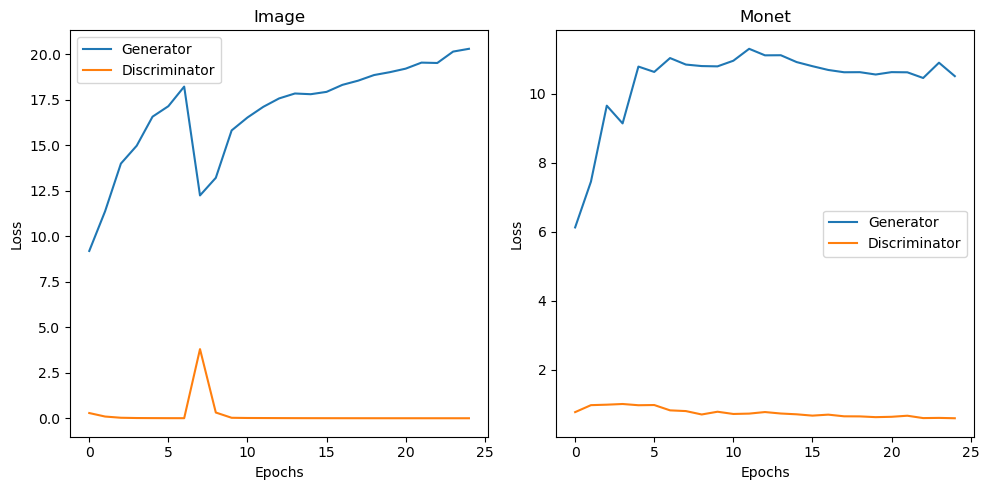

In [ ]:
titles = {"photo": "Image", "monet": "Monet"}

f, axs = plt.subplots(1, len(epoch_history), figsize=(10, 5))

for (key, losses), ax in zip(epoch_history.items(), axs.flatten()):
    ax.plot(epoch_history[key]["gen"], label="Generator")
    ax.plot(epoch_history[key]["disc"], label="Discriminator")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(titles[key])
    ax.legend()

plt.tight_layout()

# Visualize Monet-esque photos

In [ ]:
# Select random TFRecord files from the dataset
random_tfrecord_files = random.sample(PHOTO_FILES, num_images)

# Load and decode the selected TFRecord files to obtain image tensors
random_photo_ds = load_dataset(random_tfrecord_files, labeled=True).batch(1)

# Iterate over the selected random photo dataset
for example_photo in random_photo_ds:
    # Convert the photo to a Monet-style painting using the generator
    converted_monet = monet_generator(example_photo, training=False)[0]

    # Plot the original photo and the converted Monet-style painting side by side
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title('Original Photo')
    plt.imshow(example_photo[0] * 0.5 + 0.5)  # De-normalize the photo
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Converted Monet-style Painting')
    plt.imshow(converted_monet * 0.5 + 0.5)  # De-normalize the converted Monet image
    plt.axis('off')

    plt.show()
